# Model selection and model evaluation

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, learning_curve
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import register_matplotlib_converters
import warnings
import time

start_time = time.time()

**Set options**

In [2]:
warnings.filterwarnings('ignore')
register_matplotlib_converters()
pd.set_option('display.max_columns', 2500, 'display.max_rows', 2500, 'display.width', None)

**Load the data**

In [3]:
dataframe = pd.read_csv("../input/malaria-dataframe/MalariaConstant.csv", sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
dataframe.set_index(['Date'], inplace=True)
dataframe[['Quantity']] = dataframe[['Quantity']].astype('int32')  # Quantity to integer
dataframe = dataframe.sort_values(['Date'])

**Create the classifier column**

In [4]:
# 0 if Quantity = 0, 1 otherwise
dataframe['Classifier'] = np.nan
dataframe['Classifier'].values[dataframe['Quantity'].values == 0] = 0
dataframe['Classifier'].values[dataframe['Quantity'].values > 0] = 1

**Overview of the dataset**

In [5]:
print('Total data: {} observations'.format(len(dataframe)))
print('Quantity = 0: {0} observations ({1} % of the total data)'.format(
    len(dataframe.loc[dataframe['Classifier'] == 0]),
    round(len(dataframe.loc[dataframe['Classifier'] == 0]) / len(dataframe) * 100)))
print('Quantity > 0: {0} observations ({1} % of the total data)'.format(
    len(dataframe.loc[dataframe['Classifier'] == 1]),
    round(len(dataframe.loc[dataframe['Classifier'] == 1]) / len(dataframe) * 100)))

Total data: 36384 observations
Quantity = 0: 9409 observations (26 % of the total data)
Quantity > 0: 26975 observations (74 % of the total data)


**Determine the train/test split**

In [6]:
# Split total data into trainval and test set
dataframe = dataframe.reset_index()
dataframe['Date'] = pd.to_datetime(dataframe['Date'])

split_date = pd.datetime(2018, 12, 30)  # Determine where to split the dataset
df_trainval = dataframe.loc[dataframe['Date'] <= split_date]  # Training set = before splitDate
df_test = dataframe.loc[dataframe['Date'] > split_date]  # Test set = after splitDate

# Week of train test split
date_highlight = df_test.reset_index()['Date'][0]  # Date of train test split
highlight = pd.DataFrame(dataframe.reset_index()['Date'].unique(), columns=['Date'])
highlight = highlight.sort_values(by=['Date']).reset_index(drop=True)
highlight = int(highlight[highlight['Date'] == date_highlight].index.values.astype(int))
print('The train test split is between week {0} and {1}.'.format(highlight - 1, highlight))  # Train test split week

The train test split is between week 103 and 104.


## Random Forest Classifier

### Model selection (Random Forest Classifier)

**Train/test split (Random Forest Classifier)**

Train/test split (Random Forest Classifier):
Size training set: 27523 observations (76 % of the total data)
Size test set: 8861 observations (24 % of the total data)


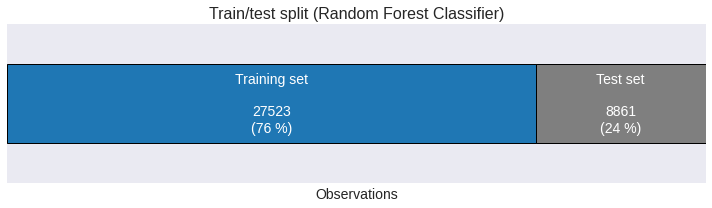

In [7]:
# Train/test split (Random Forest Classifier)
print('Train/test split (Random Forest Classifier):')
print('Size training set: {0} observations ({1} % of the total data)'.format(
    len(df_trainval), (round(len(df_trainval) / (len(df_trainval) + len(df_test)) * 100))))
print('Size test set: {0} observations ({1} % of the total data)'.format(
    len(df_test), (round(len(df_test) / (len(df_trainval) + len(df_test)) * 100))))

# Figure: Train/test split (Random Forest Classifier)
plt.figure(figsize=(10, 3))
plt.style.use('seaborn-darkgrid')
plt.barh(1.5, len(df_trainval), height=1.5, color='#1f77b4', edgecolor='black')
plt.text(len(df_trainval) / 2, 1.5, 'Training set\n\n{0}\n({1} %)'.format(
    len(df_trainval), round(len(df_trainval) / (len(df_trainval) + len(df_test)) * 100)),
         ha='center', va='center', fontsize=14, color='white')
plt.barh(1.5, len(df_test), height=1.5, left=len(df_trainval), color='#7f7f7f', edgecolor='black')
plt.text(len(df_trainval) + len(df_test) / 2, 1.5, 'Test set\n\n{0}\n({1} %)'.format(
    len(df_test), round(len(df_test) / (len(df_trainval) + len(df_test)) * 100)),
         ha='center', va='center', fontsize=14, color='white')
plt.title('Train/test split (Random Forest Classifier)', fontsize=16)
plt.xlabel('Observations', fontsize=14), plt.xticks([]), plt.yticks([])
plt.xlim(0, len(df_trainval) + len(df_test)), plt.ylim(0, 3)
plt.tight_layout()
plt.show()

# Determine the number of CV splits
TimeSeriesSplit = TimeSeriesSplit(n_splits=10) 

**Target value & estimators (Random Forest)**

In [8]:
# Target value (Random Forest)
y_trainval_RF = np.ravel(df_trainval[['Classifier']])
y_test_RF = np.ravel(df_test[['Classifier']])

# Estimators (Random Forest)
X_trainval_RF = df_trainval.loc[:, 'Quantity_individual_1':'Price']
X_test_RF = df_test.loc[:, 'Quantity_individual_1':'Price']

# Fit Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_trainval_RF, y_trainval_RF);

Feature importance (Random Forest Classifier):

In [9]:
feature_importance_RF = pd.DataFrame({'Feature': X_trainval_RF.columns,
                                    'Relative Importance': random_forest.feature_importances_})
print('Random Forest features:', random_forest.n_features_)

# Sort the features by absolute coefficient values and calculate relative importance
feature_importance_RF = feature_importance_RF.iloc[
    feature_importance_RF['Relative Importance'].abs().argsort()[::-1]].reset_index(drop=True)

Random Forest features: 8


In [10]:
feature_importance_RF

,Feature,Relative Importance
0,Quantity_pharmacy_1,0.260552
1,Quantity_individual.avg_4,0.131550
2,Price,0.118614
3,Quantity_total_1,0.117650
4,Quantity_individual.avg_2,0.114013
5,Pharmacy_1,0.108334
6,Quantity_individual_1,0.082057
7,Frequency_individual_1,0.067230


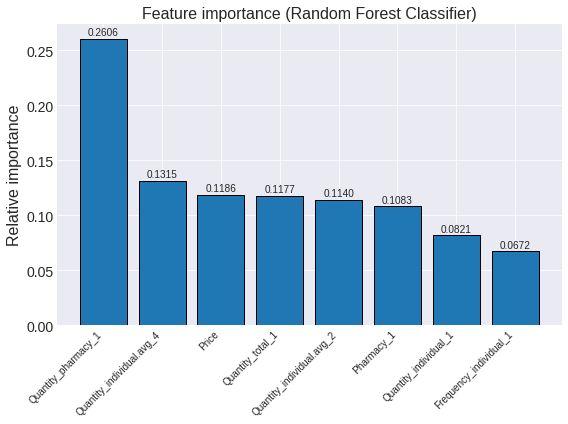

In [11]:
# Figure: Feature importance (Random Forest Classifier)
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')
plt.bar(feature_importance_RF['Feature'], feature_importance_RF['Relative Importance'], edgecolor='black')
plt.title('Feature importance (Random Forest Classifier)', fontsize=16)
plt.ylabel('Relative importance', fontsize=16)
if len(list(feature_importance_RF['Relative Importance'])) < 10:
    for i, v in enumerate(np.around(np.array(feature_importance_RF['Relative Importance']), 4)):
        plt.text(i, v + 0.003, str('%.4f' % v), ha='center', fontsize=10)  # Force every value to have 2 decimal places
plt.xticks(rotation=45, ha='right'), plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Make Random Forest predictions

In [12]:
prediction_classification_training = pd.DataFrame({'Actual': y_trainval_RF,
                                                 'Prediction Classification': random_forest.predict(X_trainval_RF)},
                                                columns=['Actual', 'Prediction Classification'])
prediction_classification_test = pd.DataFrame({'Actual': y_test_RF,
                                             'Prediction Classification': random_forest.predict(X_test_RF)},
                                            columns=['Actual', 'Prediction Classification'])
prediction_classification = pd.concat([prediction_classification_training,
                                      prediction_classification_test]).reset_index(drop=True)

# Results (Random Forest Classifier)
print('Predictions total (Random Forest Classifier):', len(prediction_classification))
print('Predictions training set (Random Forest Classifier):', len(prediction_classification_training))
print('Predictions test set (Random Forest Classifier):', len(prediction_classification_test))

print('\nPerformance (Random Forest Classifier):')
print('Accuracy training set: {:.4f}'.format(random_forest.score(X_trainval_RF, y_trainval_RF)))
print('Accuracy test set: {:.4f}'.format(random_forest.score(X_test_RF, y_test_RF)))

Predictions total (Random Forest Classifier): 36384
Predictions training set (Random Forest Classifier): 27523
Predictions test set (Random Forest Classifier): 8861

Performance (Random Forest Classifier):
Accuracy training set: 0.9989
Accuracy test set: 0.7886


### Model evaluation (Random Forest Classifier)

**Predicted class vs. true quantity (Random Forest Classifier)**

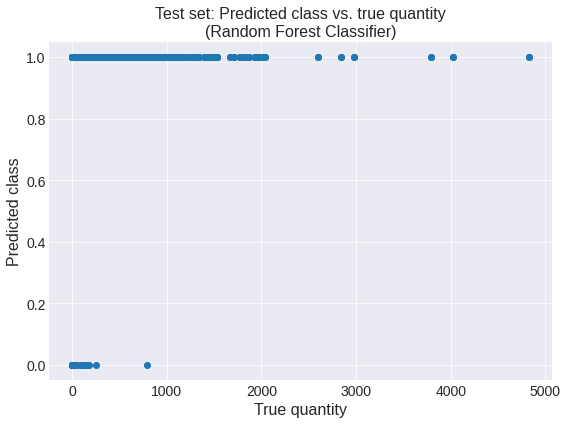

In [13]:
# Figure: Test set: Predicted class vs. true quantity (Random Forest Classifier)
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')
plt.plot(np.ravel(df_test[['Quantity']]), prediction_classification_test, 'o', color='#1f77b4')
plt.title('Test set: Predicted class vs. true quantity\n(Random Forest Classifier)', fontsize=16)
plt.xlabel('True quantity', fontsize=16), plt.ylabel('Predicted class', fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

**Confusion matrix: Random Forest Classifier**

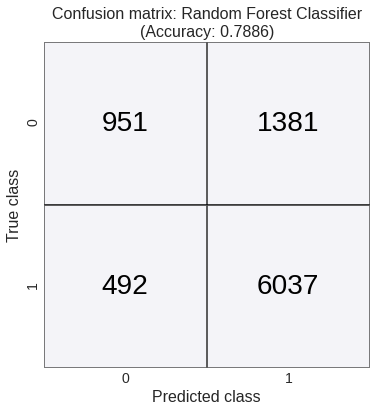

In [14]:
# Figure: Confusion matrix: Random Forest Classifier
confusion_matrix = confusion_matrix(y_test_RF, prediction_classification_test['Prediction Classification'].tolist())

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 28, 'color': 'black'}, fmt='d', cbar=False, linewidths=1,
            linecolor='black', square=True, cmap=['white'], alpha=0.5)
plt.title('Confusion matrix: Random Forest Classifier\n(Accuracy: {0:.4f})'
          .format(accuracy_score(y_test_RF, prediction_classification_test['Prediction Classification'].tolist())),
          fontsize=16)
plt.xlabel('Predicted class', fontsize=16), plt.ylabel('True class', fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.show()

## LASSO

### Model selection (LASSO)

In [15]:
df_trainval = pd.concat([df_trainval.reset_index(drop=True), prediction_classification_training], axis=1)
df_test = pd.concat([df_test.reset_index(drop=True), prediction_classification_test], axis=1)

# Only take the values that had not been predicted 0 by random forest
df_trainval = df_trainval.loc[df_trainval['Prediction Classification'] == 1]
df_test = df_test.loc[df_test['Prediction Classification'] == 1]

print('Train test split (LASSO):')
print('Size training set: {0} observations ({1} % of the LASSO data)'.format(
    len(df_trainval), (round(len(df_trainval) / (len(df_trainval) + len(df_test)) * 100))))
print('Size test set: {0} observations ({1} % of the LASSO data)'.format(
    len(df_test), (round(len(df_test) / (len(df_trainval) + len(df_test)) * 100))))
print('* Note: LASSO only predicts sales quantities that had been predicted 1 by Random Forest Classifier *')

Train test split (LASSO):
Size training set: 20445 observations (73 % of the LASSO data)
Size test set: 7418 observations (27 % of the LASSO data)
* Note: LASSO only predicts sales quantities that had been predicted 1 by Random Forest Classifier *


**Train/test split (LASSO)**

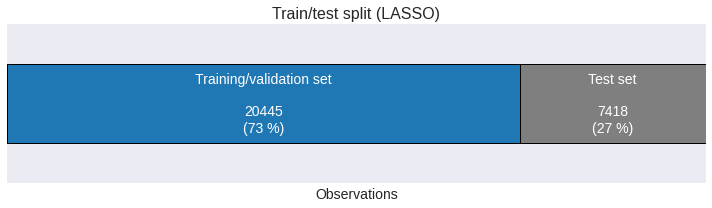

In [16]:
# Figure: Train/test split (LASSO)
plt.figure(figsize=(10, 3))
plt.style.use('seaborn-darkgrid')
plt.barh(1.5, len(df_trainval), height=1.5, color='#1f77b4', edgecolor='black')
plt.text(len(df_trainval) / 2, 1.5, 'Training/validation set\n\n{0}\n({1} %)'.format(
    len(df_trainval), round(len(df_trainval) / (len(df_trainval) + len(df_test)) * 100)),
         ha='center', va='center', fontsize=14, color='white')
plt.barh(1.5, len(df_test), height=1.5, left=len(df_trainval), color='#7f7f7f', edgecolor='black')
plt.text(len(df_trainval) + len(df_test) / 2, 1.5, 'Test set\n\n{0}\n({1} %)'.format(
    len(df_test), round(len(df_test) / (len(df_trainval) + len(df_test)) * 100)),
         ha='center', va='center', fontsize=14, color='white')
plt.title('Train/test split (LASSO)', fontsize=16)
plt.xlabel('Observations', fontsize=14)
plt.xticks([]), plt.yticks([])
plt.xlim(0, len(df_trainval) + len(df_test)), plt.ylim(0, 3)
plt.tight_layout()
plt.show()

**Target values & estimators (LASSO)**

In [17]:
# Target value (LASSO)
y_trainval = np.ravel(df_trainval[['Quantity']])
y_test = np.ravel(df_test[['Quantity']])

# Estimators (LASSO)
X_trainval = df_trainval.loc[:, 'Quantity_individual_1':'Strength_s']
X_test = df_test.loc[:, 'Quantity_individual_1':'Strength_s']

# Fit LASSO
lassocv = LassoCV(alphas=None, n_alphas=20, cv=TimeSeriesSplit, max_iter=100000)
lassocv.fit(X_trainval, y_trainval);

**Time series cross-validation**

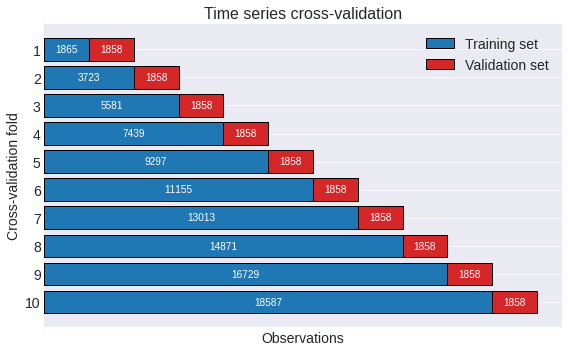

In [18]:
# Figure: Time series cross-validation
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-darkgrid')
count = 0
for train, validation in TimeSeriesSplit.split(X_trainval):
    count += 1
    plt.barh(count, len(train), color='#1f77b4', edgecolor='black')
    plt.text(len(train) / 2, count, len(train),
             ha='center', va='center', fontsize=10, color='white')
    plt.barh(count, len(validation), left=len(train), color='#d62728', edgecolor='black')
    plt.text(len(train) + (len(validation) / 2), count, len(validation),
             ha='center', va='center', fontsize=10, color='white')
plt.title('Time series cross-validation', fontsize=16)
plt.xlabel('Observations', fontsize=14), plt.ylabel('Cross-validation fold', fontsize=14)
plt.xticks([]), plt.yticks(list(range(1, 11)), fontsize=14)
plt.legend(['Training set', 'Validation set'], fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Shape of generated regularization parameters alpha**

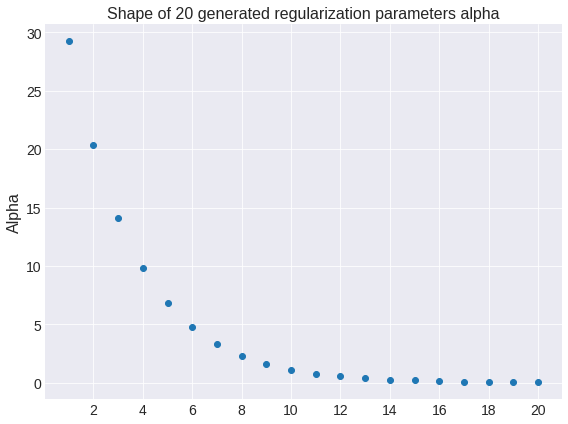

In [19]:
# Figure: Shape of generated regularization parameters alpha
alphas = list(lassocv.alphas_)

plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')
plt.plot(list(range(len(alphas))), list(alphas), 'o', color='#1f77b4')
plt.title('Shape of {} generated regularization parameters alpha'.format(len(alphas)), fontsize=16)
plt.ylabel('Alpha', fontsize=16)
plt.xticks(range(1, len(alphas) + 1, 2), range(2, len(alphas) + 2, 2), fontsize=14), plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

**Cross-validation results**

Cross-validation scores: [0.896, 0.674, 0.569, 0.911, 0.893, 0.691, 0.858, 0.706, 0.851, 0.906]
Cross-validation average score: 0.796
Best alpha: 0.06048


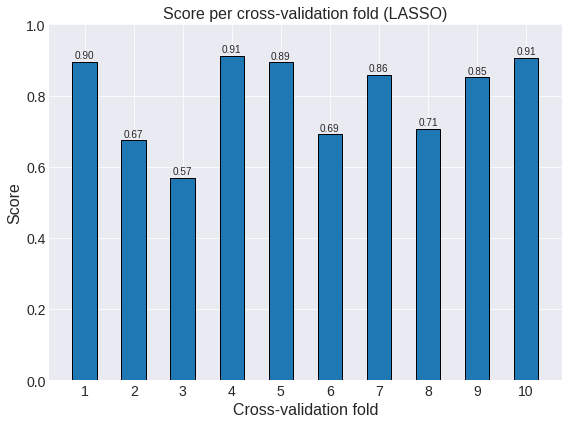

In [20]:
# Cross-validation results
cv_scores = cross_val_score(lassocv, X_trainval, y_trainval, cv=TimeSeriesSplit)

print('Cross-validation scores: {}'.format(list(np.around(cv_scores, 3))))
print('Cross-validation average score: {}'.format(round(cv_scores.mean(), 3)))
print('Best alpha: {:.5f}'.format(lassocv.alpha_))  # Best alpha

# Figure: Score per cross-validation fold (LASSO)
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')
for i in range(len(cv_scores)):
    plt.bar(list(range(1, len(cv_scores) + 1))[i], cv_scores[i], width=0.5, edgecolor='black', color='#1f77b4')
plt.title('Score per cross-validation fold (LASSO)', fontsize=16)
plt.xlabel('Cross-validation fold', fontsize=16), plt.ylabel('Score', fontsize=16)
for i, v in enumerate(np.around(cv_scores, 3)):
    if 0.95 >= v >= 0:
        plt.text(i + 1, v + 0.01, str('%.2f' % v), ha='center', fontsize=10)
    elif v < 0:
        plt.text(i + 1, 0.01, str('%.2f' % v), ha='center', fontsize=10)
    elif v > 0.95:
        plt.text(i + 1, v - 0.03, str('%.2f' % v), color='white', ha='center', fontsize=10)
plt.xticks(list(range(1, len(cv_scores) + 1)), fontsize=14), plt.yticks(fontsize=14), plt.ylim((0, 1))
plt.tight_layout()
plt.show()

**Effect of regularization parameter alpha on MSE (LASSO)**

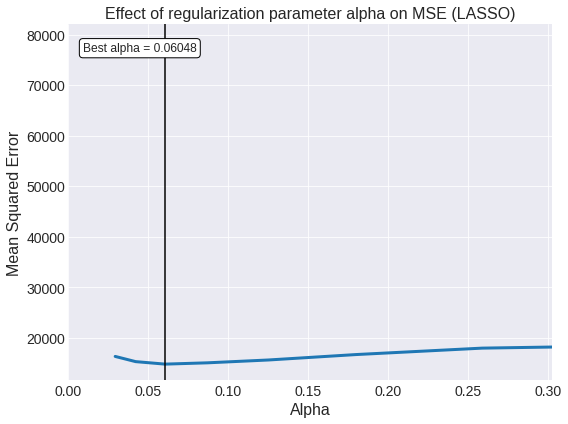

In [21]:
# Figure: Effect of regularization parameter alpha on MSE (LASSO)
mse = list(np.average(lassocv.mse_path_, axis=1))  # Average of the CV folds

plt.figure(figsize=(8, 6))  # Version 1: entire x range
plt.style.use('seaborn-darkgrid')
ax = plt.gca()
ax.plot(alphas, mse, linewidth=3)
ax.axvline(lassocv.alpha_, color='black')
ax.text(0.03, 0.95, 'Best alpha = {}'.format(round(lassocv.alpha_, 5)), transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=1, boxstyle='round'))
plt.title('Effect of regularization parameter alpha on MSE (LASSO)', fontsize=16)
plt.xlabel('Alpha', fontsize=16), plt.ylabel('Mean Squared Error', fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.xlim(0, min(lassocv.alpha_ * 5, max(alphas)))
plt.tight_layout()
plt.show()

In [22]:
alphas = pd.DataFrame(alphas, columns=['Alpha'])
coefficient_path = lassocv.path(X_trainval, y_trainval, alphas=alphas)
coefficients = pd.DataFrame(coefficient_path[1], index=X_trainval.columns).T.iloc[::-1].reset_index(drop=True)
result = pd.concat([alphas, coefficients], axis=1, sort=False)
best_alpha = result[result['Alpha'] == lassocv.alpha_].tail(1)
used_features = best_alpha.columns[(best_alpha != 0).iloc[0]].tolist()
used_features.remove('Alpha')

# Best coefficients
best_coefficients = best_alpha[best_alpha['Alpha'] == lassocv.alpha_].reset_index(drop=True)
best_coefficients = best_coefficients.drop(['Alpha'], axis=1)
best_coefficients = best_coefficients.iloc[0]
best_coefficients = pd.DataFrame({'Feature': best_coefficients.index, 'Coefficient': best_coefficients.values},
                                columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False) \
    .reset_index(drop=True)  # Feature names and coefficients to dataframe

print('Result: At the best alpha', round(lassocv.alpha_, 5), 'LASSO set', sum(best_coefficients['Coefficient'] == 0),
      'of the total', len(best_coefficients['Coefficient']), 'features equal to zero.')

Result: At the best alpha 0.06048 LASSO set 1270 of the total 1436 features equal to zero.


**Feature selection**

In [23]:
print('Features:', len(best_coefficients['Coefficient']))
print('\nLASSO selected {} features:\n'.format(sum(best_coefficients['Coefficient'] != 0)), used_features)

# Detailed information about which features are selected by LASSO
a = pd.DataFrame({range(0, len(used_features))}, columns=used_features)

print('\nDataset-related features:')
print('Quantity/Frequency/Pharmacy/Price:', len(a.filter(regex='Quantity_|Frequency_|Pharmacy_1|Price').columns))
print('Pharmacy features (one-hot encoding):', len(a.filter(regex='Pharmacy_Pharmacy').columns))
print('Product features (one-hot encoding):', len(a.filter(regex='Product_').columns))
print('Brand features (one-hot encoding):', len(a.filter(regex='Brand_').columns))
print('Strength features (one-hot encoding):', len(a.filter(regex='Strength_').columns))

print('\nAdditional external features:')
print('Weather:', len(a.filter(regex='Precip|Humidity|WindSpeed|CloudCover|UVIndex|Temp').columns))
print('Trends:', len(a.filter(regex='Disease|Pain|Malaria|Influenza')
                     .columns))  # remove MalariaCases and MalariaDeaths from this group
print('Health/Holiday:', len(a.filter(regex='MalariaCases|MalariaDeaths|AirPollution|Holiday').columns))

Features: 1436

LASSO selected 166 features:
 ['Quantity_individual_1', 'Quantity_individual.avg_4', 'Quantity_individual.avg_2', 'Quantity_pharmacy_1', 'Pharmacy_1', 'Frequency_individual_1', 'CloudCover', 'TempMin', 'Humidity.avg_5', 'Humidity.avg.Lag1_5', 'Humidity.avg.Lag4_6', 'Humidity.LookAhead_1', 'WindSpeed_1', 'WindSpeed.avg.Lag1_5', 'WindSpeed.avg.Lag4_6', 'CloudCover_1', 'CloudCover.avg.Lag2_5', 'UVIndex_1', 'UVIndex.avg_5', 'TempMax_1', 'Disease.Lag1_1', 'Pain.Lag1_1', 'Influenza.Lag1_1', 'Disease.Lag5_1', 'Malaria.Lag5_1', 'Influenza.Lag5_1', 'Malaria.avg.Lag2_5', 'Disease.roc.Lag1_4', 'Pain.roc.Lag1_4', 'Influenza.roc.Lag1_4', 'PrecipProb CloudCover TempMin', 'PrecipProb CloudCover TempMax', 'Humidity^2 UVIndex', 'CloudCover^3', 'TempMax^3', 'Disease^2 Influenza', 'Pain^3', 'Quantity_individual_1 Quantity_pharmacy_1', 'Quantity_individual_1 Frequency_individual_1', 'Quantity_individual.avg_4^2', 'Quantity_individual.avg_4 Quantity_individual.avg_2', 'Quantity_individual.a

**Feature importance (LASSO)**

In [24]:
# Sort the features by absolute coefficient values and calculate relative importance
feature_coefficients = best_coefficients.iloc[best_coefficients['Coefficient'].abs().argsort()[::-1]].reset_index(drop=True)
feature_coefficients = feature_coefficients[feature_coefficients['Coefficient'] != 0]  # Drop features with coefficient 0
feature_coefficients['Normalized Relative Coefficient'] = (abs(feature_coefficients['Coefficient']) /
                                                           max(abs(feature_coefficients['Coefficient'])))
feature_coefficients[:50] # Only top 50 coefficients for better visibility

,Feature,Coefficient,Normalized Relative Coefficient
0,Quantity_pharmacy_1 Frequency_individual_1,3916.373380,1.000000
1,Quantity_individual_1 Quantity_pharmacy_1,3745.181964,0.956288
2,Quantity_individual_1,3245.665327,0.828743
3,Quantity_individual.avg_4 Quantity_pharmacy_1,3194.351642,0.815640
4,Quantity_individual_1 Quantity_individual.avg_...,-2697.631293,0.688809
5,Quantity_individual_1 Frequency_individual_1,-2017.478417,0.515139
6,Quantity_individual.avg_2^2,-1948.504037,0.497528
7,Quantity_individual.avg_2,1226.619972,0.313203
8,Quantity_individual.avg_4,1015.432802,0.259279
9,Quantity_individual.avg_4 Quantity_individual....,-383.807615,0.098001


**Feature importance of the 10 features with the highest coefficients (LASSO)**

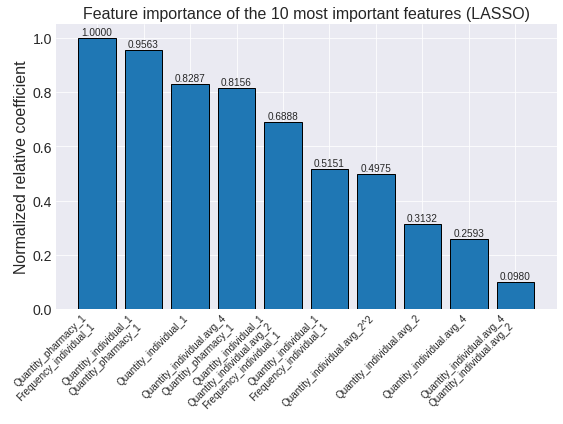

In [25]:
# Figure: Feature importance of the 10 features with the highest coefficients (LASSO)
feature_coefficients_lean = feature_coefficients[:10] # Only top 10 coefficients for better visibility
x_ticks = [label.replace(' ', '\n') for label in feature_coefficients_lean['Feature']]  # line break for polynomial features

plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')
plt.bar(feature_coefficients_lean['Feature'], feature_coefficients_lean['Normalized Relative Coefficient'], edgecolor='black')
plt.title('Feature importance of the 10 most important features (LASSO)', fontsize=16)
plt.ylabel('Normalized relative coefficient', fontsize=16)
plt.xticks(range(0, len(feature_coefficients_lean['Feature'])), x_ticks, ha='right', rotation=45, fontsize=10)
plt.yticks(fontsize=14)
for i, v in enumerate(np.around(np.array(feature_coefficients_lean['Normalized Relative Coefficient']), 4)):
    plt.text(i, v + 0.01, str('%.4f' % v), ha='center', fontsize=10)  # Force every value to have 2 decimal places
plt.tight_layout()
plt.show()

**At which alpha are the features dropped by LASSO:**

In [26]:
print('At which alpha are the features dropped by LASSO:')
result = result.abs().sort_values(by=list(range(len(alphas))), axis=1)
for column in result:
    result[column + 'New'] = 0
    result.loc[result[column].ne(0).idxmax(), column + 'New'] = 1
    result[column + 'New'] = result[column + 'New'].shift(-1).fillna(0)
    if result[column].name != 'Alpha' and result[column + 'New'].max() != 0:
        print(
            '{0}: {1}'.format(result[column].name, round(result.loc[result[column + 'New'] == 1, 'Alpha'].iloc[0], 5)))
    elif result[column].name != 'Alpha' and result[column + 'New'].max() == 0 and result[column].max() != 0:
        print('{0}: Coefficient not dropped yet at maximum alpha value {1}'.format(result[column].name,
                                                                                   round(result['Alpha'].max(), 5)))
    elif result[column].name != 'Alpha' and result[column + 'New'].max() == 0 and result[column].max() == 0:
        print('{0}: Coefficient dropped before minimum alpha value {1}'.format(result[column].name,
                                                                               round(result['Alpha'].min(), 5)))

At which alpha are the features dropped by LASSO:
Price: Coefficient dropped before minimum alpha value 0.02923
PrecipInt: Coefficient dropped before minimum alpha value 0.02923
PrecipProb: Coefficient dropped before minimum alpha value 0.02923
Humidity: Coefficient dropped before minimum alpha value 0.02923
WindSpeed: Coefficient dropped before minimum alpha value 0.02923
UVIndex: Coefficient dropped before minimum alpha value 0.02923
TempMax: Coefficient dropped before minimum alpha value 0.02923
PrecipInt.avg_2: Coefficient dropped before minimum alpha value 0.02923
PrecipInt.avg.Lag1_5: Coefficient dropped before minimum alpha value 0.02923
PrecipInt.5W.avg.Lag2: Coefficient dropped before minimum alpha value 0.02923
PrecipInt.5W.avg.Lag3: Coefficient dropped before minimum alpha value 0.02923
PrecipInt.6W.avg.Lag4: Coefficient dropped before minimum alpha value 0.02923
PrecipInt.LookAhead_1: Coefficient dropped before minimum alpha value 0.02923
PrecipInt.LookAhead_2: Coefficient 

**Effect of regularization parameter alpha on coefficients (LASSO)**

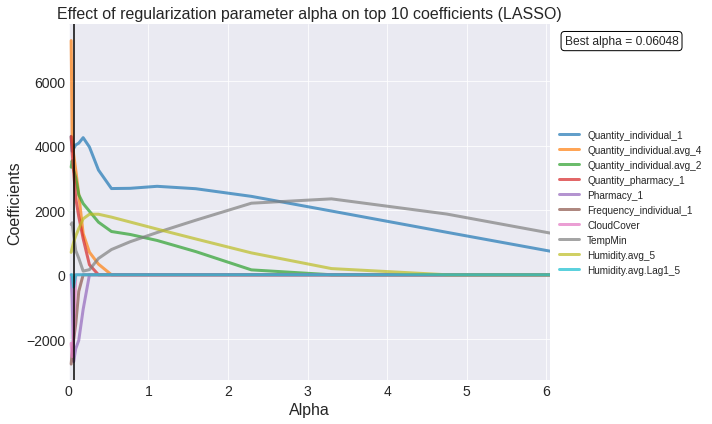

In [27]:
# Remove the columns New that have been created to extract to determine at which alpha LASSO drops a feature
result = result[result.columns.drop(list(result.filter(regex='New')))]

# Figure: Effect of regularization parameter alpha on coefficients (LASSO)
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-darkgrid')
ax = plt.gca()
plt.plot(alphas, coefficients[list(feature_coefficients_lean['Feature'])], marker='', linewidth=3, alpha=0.7)
plt.legend(coefficients[used_features], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title('Effect of regularization parameter alpha on top 10 coefficients (LASSO)', fontsize=16)
plt.xlabel('Alpha', fontsize=16), plt.ylabel('Coefficients', fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.xlim(0, min(lassocv.alpha_ * 100, max(list(lassocv.alphas_))))
ax.text(1.03, 0.97, 'Best alpha = {}'.format(round(lassocv.alpha_, 5)), transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=1, boxstyle='round'))
plt.axvline(lassocv.alpha_, color='black')  # Highlight best alpha
plt.tight_layout()
plt.show()

**Make LASSO predictions**

In [28]:
# Make LASSO predictions
prediction_lasso_training = pd.DataFrame({'Prediction LASSO': lassocv.predict(X_trainval)}, columns=['Prediction LASSO'])
prediction_lasso_test = pd.DataFrame({'Prediction LASSO': lassocv.predict(X_test)}, columns=['Prediction LASSO'])
prediction_lasso = pd.concat([prediction_lasso_training, prediction_lasso_test]).reset_index(drop=True)

# Replace each 1 by the respective LASSO forecast
count = 0
for value in prediction_classification['Prediction Classification'].index:
    if prediction_classification['Prediction Classification'][value] != 0:
        prediction_classification['Prediction Classification'][value] = \
            prediction_lasso['Prediction LASSO'].tolist()[count]
        count += 1

# Add predictions to dataframe
dataframe = pd.concat([dataframe, prediction_classification['Prediction Classification']], axis=1)
dataframe = dataframe.rename({'Prediction Classification': 'Prediction'}, axis=1)

### Model evaluation (Random Forest)

**Results (LASSO)**

In [29]:
# Results (LASSO)
print('Predictions total (LASSO):', len(prediction_lasso))
print('Predictions training set (LASSO):', len(prediction_lasso_training))
print('Predictions test set (LASSO):', len(prediction_lasso_test))

print('\nPerformance (LASSO):')
print('R2 training set: {:.3f}'.format(lassocv.score(X_trainval, y_trainval)))
print('R2 test set: {:.3f}'.format(lassocv.score(X_test, y_test)))

# Set negative predictions equal to zero
dataframe['Prediction'] = dataframe['Prediction'].mask(dataframe['Prediction'] < 0, 0)
# Round predictions to integers
dataframe['Prediction'] = round(dataframe['Prediction'])
dataframe['Prediction'] = dataframe['Prediction'].astype('int32')

Predictions total (LASSO): 27863
Predictions training set (LASSO): 20445
Predictions test set (LASSO): 7418

Performance (LASSO):
R2 training set: 0.849
R2 test set: 0.818


**Learning curve (LASSO)**

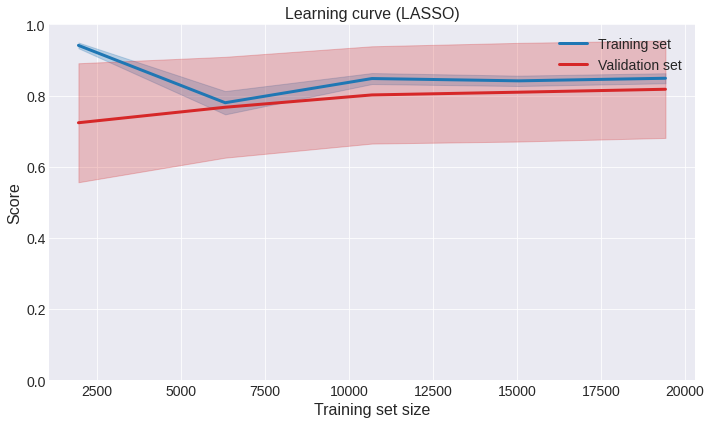

In [30]:
# Figure: Learning curve (LASSO)
train_sizes, train_scores, test_scores = learning_curve(lassocv, X_trainval, y_trainval, cv=20)  # Number of splits above
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-darkgrid')
plt.plot(train_sizes, train_mean, color='#1f77b4', label='Training set', linewidth=3)  # Draw lines train
plt.plot(train_sizes, test_mean, color='#d62728', label='Validation set', linewidth=3)  # Draw lines CV
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#1f77b4', alpha=0.25)  # Draw band train
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='#d62728', alpha=0.25)  # Draw band CV
plt.title('Learning curve (LASSO)', fontsize=16)
plt.xlabel('Training set size', fontsize=16), plt.ylabel('Score', fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14), plt.ylim(0, 1)
plt.legend(fontsize=14, loc='best')
plt.tight_layout()
plt.show()

**MSE & MAE (Random Forest Classifier & LASSO)**

In [31]:
# MSE & MAE (Random Forest Classifier & LASSO)
print('Performance (Random Forest Classifier & LASSO):')
print('MSE training set: {:.3f}'.format(mean_squared_error(
    dataframe['Quantity'][:len(X_trainval_RF)].tolist(),
    dataframe['Prediction'][:len(X_trainval_RF)].tolist())))
print('MSE test set: {:.3f}'.format(mean_squared_error(
    dataframe['Quantity'][len(X_trainval_RF):].tolist(),
    dataframe['Prediction'][len(X_trainval_RF):].tolist())))
print('\nMAE training set: {:.3f}'.format(mean_absolute_error(
    dataframe['Quantity'][:len(X_trainval_RF)].tolist(),
    dataframe['Prediction'][:len(X_trainval_RF)].tolist())))
print('MAE test set: {:.3f}'.format(mean_absolute_error(
    dataframe['Quantity'][len(X_trainval_RF):].tolist(),
    dataframe['Prediction'][len(X_trainval_RF):].tolist())))

Performance (Random Forest Classifier & LASSO):
MSE training set: 10065.192
MSE test set: 5771.133

MAE training set: 26.097
MAE test set: 26.207


**True vs. predicted quantity (Random Forest Classifier & LASSO)**

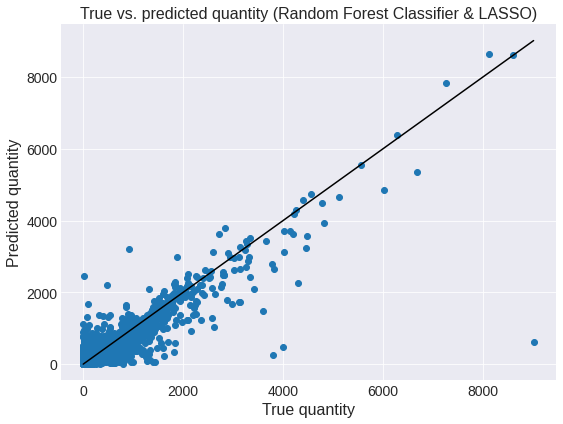

In [32]:
dataframe_result = dataframe[['Date', 'Pharmacy', 'Product', 'Brand', 'Strength', 'Country', 'City', 'Year', 'Week',
                             'Quantity', 'Prediction']]

# Figure: True vs. predicted quantity (Random Forest Classifier & LASSO)
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')
plt.plot(dataframe_result['Quantity'], dataframe_result['Prediction'], 'o', color='#1f77b4')
plt.plot(list(range(0, (int(round((dataframe_result[['Quantity', 'Prediction']].max()).max()))))),
         list(range(0, (int(round((dataframe_result[['Quantity', 'Prediction']].max()).max()))))), 'black')
plt.title('True vs. predicted quantity (Random Forest Classifier & LASSO)', fontsize=16)
plt.xlabel('True quantity', fontsize=16), plt.ylabel('Predicted quantity', fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

**True vs. predicted quantity over time (Random Forest Classifier & LASSO)**

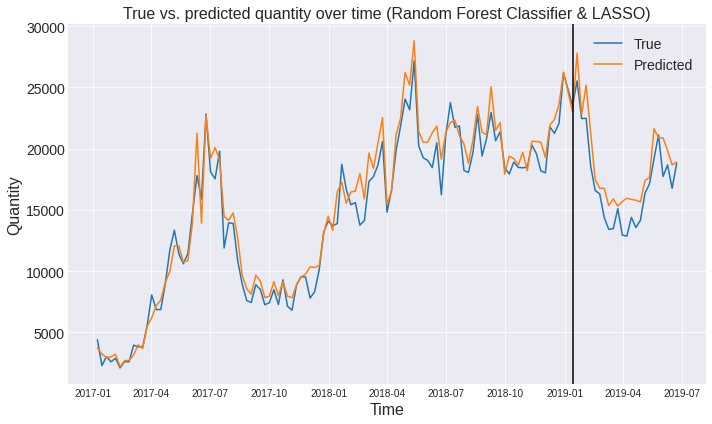

In [33]:
# Total quantity and prediction
total_quantity = dataframe.groupby(['Date'])['Quantity'].sum().reset_index()
total_prediction = dataframe.groupby(['Date'])['Prediction'].sum().reset_index()

# Figure: True vs. predicted quantity over time (Random Forest Classifier & LASSO)
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-darkgrid')
plt.plot(total_quantity['Date'].tolist(), total_quantity['Quantity'].tolist())
plt.plot(total_prediction['Date'].tolist(), total_prediction['Prediction'].tolist())
plt.axvline(date_highlight, color='black')  # Highlight training test split
plt.legend(['True', 'Predicted'], loc=1, fontsize=14)
plt.title('True vs. predicted quantity over time (Random Forest Classifier & LASSO)', fontsize=16)
plt.xlabel('Time', fontsize=16), plt.ylabel('Quantity', fontsize=16), plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [34]:
print('\n--- %s seconds ---' % round((time.time() - start_time), 2))


--- 2424.64 seconds ---
